Set the working directory and make python find the e3dsecs package

In [1]:
import os
notebook_file_path = os.path.realpath('__file__')
os.chdir(os.path.dirname(notebook_file_path))
import sys
parent_directory = os.path.dirname(notebook_file_path)
e3dsecsdir = os.path.abspath(os.path.join(parent_directory, '..'))
sys.path.append(e3dsecsdir)

Import the packages needed

In [2]:


from e3dsecs import simulation, grid, data, convection, model, diagnostics
import numpy as np
import matplotlib.pyplot as plt
import apexpy
from gemini3d.grid.convert import geog2geomag
import lompe

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 


Set various options

In [3]:
path            = '/Users/jone/Documents/uib/gemini_output/'
                       # Adjust to fit your system to find the GEMINI files
maph            = 200  # km, mapping altitude. Ions assumed fully magnetized above this alt.
extend          = 5     # How many padding "frames" used for lompe grid around 3D hor. grid
alt_layers      = np.concatenate((np.arange(90,140,5),np.arange(140,170,10), 
                                    np.arange(170,230,20),np.arange(230,500,50)))
                       # The vertical layers to be used
crop_factor     = 0.2  # How much to reduce the CS grid compared to GEMINI grid
inputmode       = 'vi' # See documentation e.g. in model.py for allowed values. 
                       # Specifies how jperp estimates are obtained
e3doubt_        = True # Wheter to use realistic variances of the observations, and add 
                       # corresponding noise
intsec          = 5*60  # Integrationtime in seconds used in E3DOUBT                       
sitelat         = 67.7# Gegraphic latitude of transmitter site location, 67.36
sitephi         = 23.0 # Gegraphic longitude of transmitter site location            
min_alt         = 90   # km, start altitude of where to sample along beams
max_alt         = 500  # km, stop altitude of where to sample along beams
dr              = 4    # altitude resolution of sampling
l1_lompe        = 1e-1 # Lompe regularization parameter 1 (model norm)
l2_lompe        = 0    # Lompe regularization parameter 2 (east-west structure)

savefigs        = True# Wheher the figures will be saved
beamfile        = 'datadict_51beams.npy' # Specifies which beam sampling file to use

Make objects containing simulation data (sim), grid (gr), sampled data(dat), and the fitted convection (conv)

In [4]:
sim = simulation.simulation(path, maph=maph)
gr = grid.grid(sim, alts=alt_layers, extend=extend, dlat=0.3, dlon=0, resolution_factor=0.45, crop_factor=crop_factor, orientation=-26)
dat = data.data(gr, sim, beams=True, sitelat=sitelat, sitephi=sitephi,
                 az=None, el=None, points=False, lat_ev=None, lon_ev=None, 
                 alt_ev=None, e3doubt_=e3doubt_, intsec = intsec, min_alt=min_alt, 
                 max_alt=max_alt, dr=dr, tempfile=beamfile)
conv = convection.convection(gr.grid_l, dat, inputmode=inputmode, e3doubt_=e3doubt_, l1_lompe=l1_lompe, 
                 l2_lompe=l2_lompe, maph=maph)

Using existing sampling file with estimated variances from E3DOUBT
saving................. : ['model', 'data_locations', 'efield', 'convection', 'ground_mag', 'electric_current', 'space_mag_fac', 'space_mag_full', 'fac', 'hall', 'pedersen', 'secs_current']
Saved Lompe file.


### Make the figure of the GEMINI simulation and how the analysis region is placed in the larger simulation context

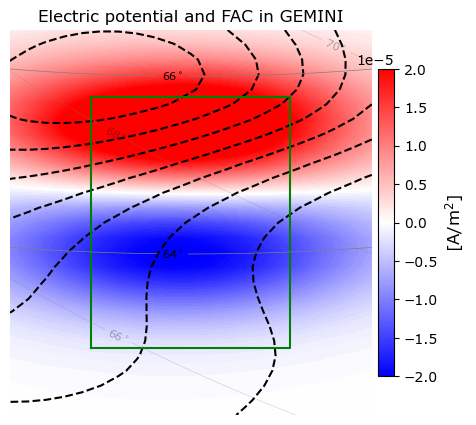

In [5]:
grid_l = gr.grid_l
extend = gr.extend
lmodel = conv.lmodel

fig = plt.figure(figsize=(5,5))
ax = plt.subplot2grid((20, 21), (0, 0), rowspan = 20, colspan = 20)
apex = apexpy.Apex(2023)
# lompe.visualization.format_ax(ax, lmodel, apex = apex)
ax.set_axis_off()
ax.set_aspect('equal')
N = lmodel.grid_E.lat.size
RE = sim.RE
shape = lmodel.grid_E.shape
_data = data.data(gr, sim, beams=False, points=True, 
                  lat_ev=lmodel.grid_E.lat.flatten(), 
                  lon_ev=lmodel.grid_E.lon.flatten(), 
                  alt_ev=np.ones(N)*lmodel.R*1e-3-RE, e3doubt_=False)

br, btheta, bphi = conv.make_b_unitvectors(_data.Bu, 
                -_data.Bn, _data.Be)

clim = 2e-5
levels = np.arange(-29000,-5000,3000)
ax.contour(lmodel.grid_E.xi, lmodel.grid_E.eta, _data.Phitop.reshape(shape), 
           colors='black', levels=levels)
levels = np.linspace(-clim,clim,100)
ax.contourf(lmodel.grid_E.xi, lmodel.grid_E.eta, -_data.fac.reshape(shape), 
            cmap='bwr', levels=levels, extend='both')

xi_corners = [grid_l.xi_mesh[0,extend],grid_l.xi_mesh[0,-extend-1],
              grid_l.xi_mesh[0,-extend-1],grid_l.xi_mesh[0,extend],grid_l.xi_mesh[0,extend]]
eta_corners = [grid_l.eta_mesh[extend,0], grid_l.eta_mesh[extend,0], 
               grid_l.eta_mesh[-extend-1,0], grid_l.eta_mesh[-extend-1,0], 
               grid_l.eta_mesh[extend,0]]
ax.plot(xi_corners, eta_corners, color='green')
ax.set_title('Electric potential and FAC in GEMINI')
# Latitude contours
levels = [62,64,66]
levels_gg = [66,68,70]
phi, theta = geog2geomag(_data.lon, _data.lat)
lat = 90-np.degrees(theta)
cc = ax.contour(lmodel.grid_E.xi, lmodel.grid_E.eta, lat.reshape(shape), 
           levels=levels, colors='grey', zorder=1000, linewidths=0.5)
labels = ax.clabel(cc, inline=True, fontsize=8, colors='k', fmt=r'%2i$^\circ$')
cc2 = ax.contour(lmodel.grid_E.xi, lmodel.grid_E.eta, _data.lat.reshape(shape), 
           levels=levels_gg, colors='grey', zorder=1000, linewidths=0.5, alpha=0.3)
labels = ax.clabel(cc2, inline=True, fontsize=8, colors='k', fmt=r'%2i$^\circ$')

#Colorbar
cbarax = plt.subplot2grid((20,21), (2, 20), rowspan = 16, colspan = 1)
cmap = plt.cm.bwr
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=-clim, vmax=clim)
cb1 = mpl.colorbar.ColorbarBase(cbarax, cmap=cmap,
                            norm=norm,
                            orientation='vertical')
cb1.set_label(r'[A/m$^2$]', fontsize=12)

if savefigs:
    fig.savefig('./plots/gemini.pdf',bbox_inches='tight')

### Make the figure that demonstrates the Lompe fit performance

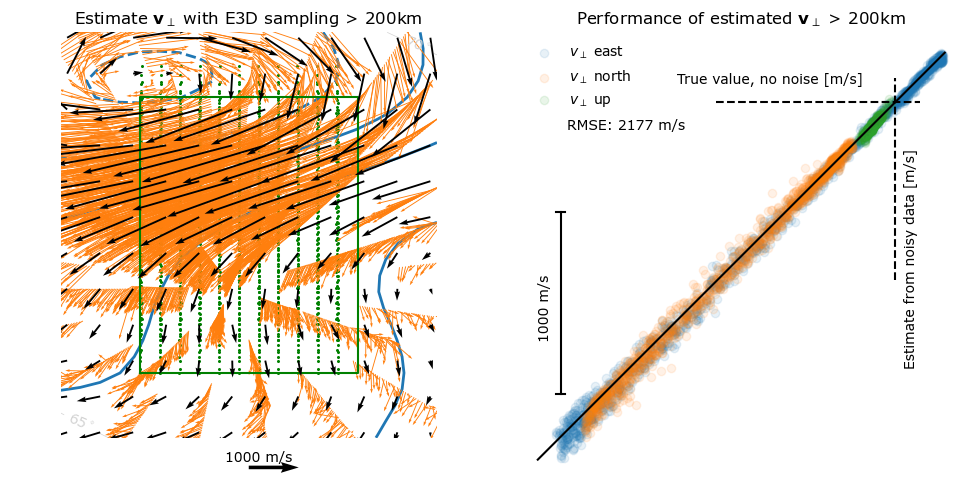

In [6]:
grid_l = gr.grid_l
extend = gr.extend
lmodel = conv.lmodel

fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot2grid((11, 20), (0, 0), rowspan = 10, colspan = 10)
ax2 = plt.subplot2grid((11, 20), (0, 10), rowspan = 11, colspan = 10)
lompe.visualization.format_ax(ax1, lmodel)
lompe.visualization.plot_quiver(ax1, lmodel, 'convection')
lompe.visualization.plot_potential(ax1, lmodel)
lompe.visualization.plot_datasets(ax1, lmodel, 'convection')
ax1.set_title(r'Estimate $\mathbf{v}_{\perp}$ with E3D sampling > ' + str(maph) + 'km')
xi_corners = [grid_l.xi_mesh[0,extend],grid_l.xi_mesh[0,-extend-1],
              grid_l.xi_mesh[0,-extend-1],grid_l.xi_mesh[0,extend],grid_l.xi_mesh[0,extend]]
eta_corners = [grid_l.eta_mesh[extend,0], grid_l.eta_mesh[extend,0], 
               grid_l.eta_mesh[-extend-1,0], grid_l.eta_mesh[-extend-1,0], 
               grid_l.eta_mesh[extend,0]]
ax1.plot(xi_corners, eta_corners, color='green')

# Right panel is showing a scatterplot of the performance of the lompe fit on data from a uniform
# mesh that was not used to make the model inthe first place
# xi_e  = grid.xi[0,1:] - grid.dxi/2 
# eta_e = grid.eta[1:,0]- grid.deta/2
alts__ = gr.alts_grid[15:]-gr.altres[15:]
xi_e  = gr.grid.xi[0,:] - gr.grid.dxi/2 
eta_e = gr.grid.eta[:,0]- gr.grid.deta/2
alt_ev, eta_ev, xi_ev = np.meshgrid(alts__, eta_e, xi_e, indexing='ij')
# eta_ev, xi_ev = np.meshgrid(eta_e, xi_e, indexing='ij')
lon_ev, lat_ev = gr.grid.projection.cube2geo(xi_ev, eta_ev) 
# alt_ev = np.ones(lon_ev.shape) * maph
_data = data.data(gr, sim, beams=False, points=True, 
                  lat_ev=lat_ev, lon_ev=lon_ev, alt_ev=alt_ev, 
                  e3doubt_=False)

axs2 = diagnostics.scatterplot_lompe(ax2, sim, _data, conv, gr)
axs2.set_title(r'Performance of estimated $\mathbf{v}_{\perp}$ > ' + str(conv.maph)+ 'km')

arrowax = plt.subplot2grid((11, 20), (10, 0), rowspan = 1, colspan = 10)
arrowax.quiver(.2, .001, 1, 0, scale = 2, scale_units = 'inches')
arrowax.text(0.45,0.7, '1000 m/s', transform=arrowax.transAxes)
arrowax.set_axis_off()

xi_map, eta_map = gr.grid.projection.geo2cube(_data.mappedglon, _data.mappedglat)
ax1.scatter(xi_map, eta_map, alpha=1, color='green', s=1.4)
plt.tight_layout()
if savefigs:
    fig.savefig('./plots/lompefit.pdf',bbox_inches='tight')


### Make figure that shows the performance of computing currents with Lompe fit vs current from GEMINI


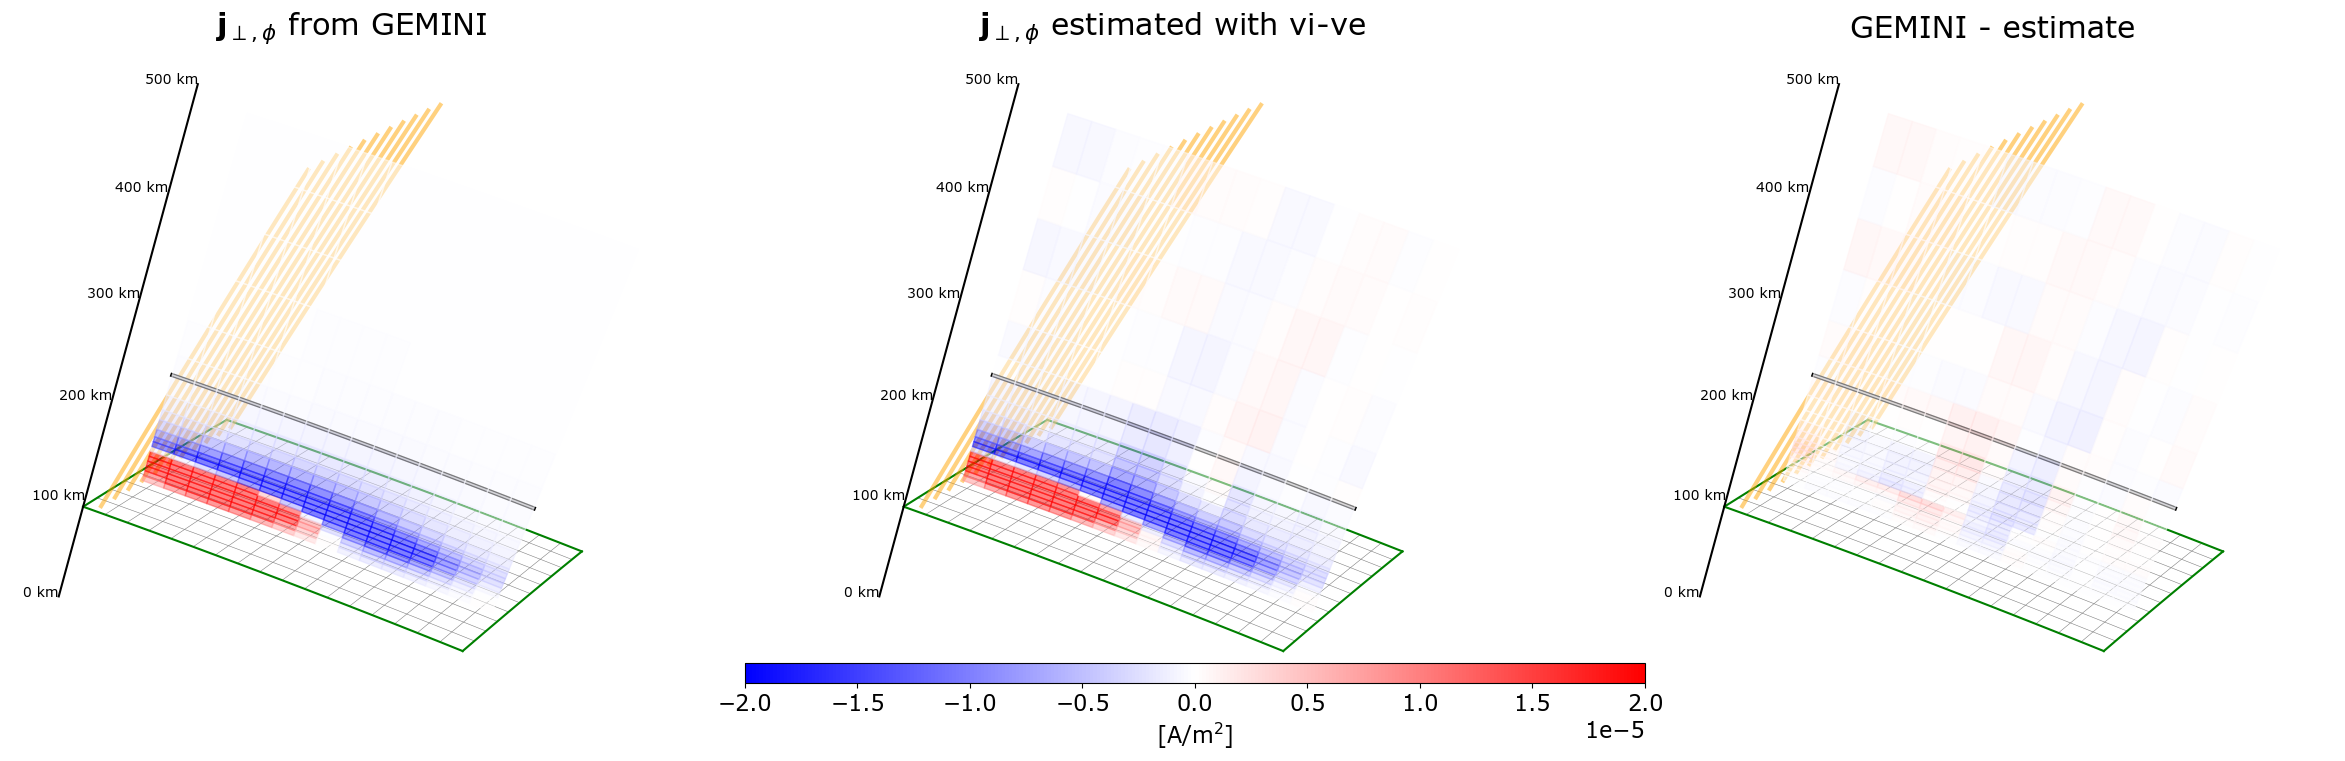

In [7]:
alts__ = gr.alts_grid[1:]-gr.altres[1:]
xi_e  = gr.grid.xi_mesh[0,1:] - gr.grid.dxi/2 
eta_e = gr.grid.eta_mesh[1:,0]- gr.grid.deta/2
alt_ev, eta_ev, xi_ev = np.meshgrid(alts__, eta_e, xi_e, indexing='ij')
lon_ev, lat_ev = gr.grid.projection.cube2geo(xi_ev, eta_ev) 
shape = lon_ev.shape
_data = data.data(gr, sim, beams=False, points=True, 
                  lat_ev=lat_ev, lon_ev=lon_ev, alt_ev=alt_ev, 
                  e3doubt_=False)
N = _data.lat.size
jjj = np.hstack((_data.jperpu,-_data.jperpn,_data.jperpe)) # jperp from GEMINI, in geo (r,theta,phi)
if not 'phitop' in inputmode:
    vperp = conv.get_E_from_lmodel(sim, _data, returnvperp=True)
    _data.vperp_electron = vperp
mod = model.model(gr)
inputdict = mod.make_inputdict(_data, gr, inputmode=inputmode, ext_factor=0, 
                    hp_from_brekke=False)
jperp_enu = np.vstack((inputdict['jperp'][0,:],inputdict['jperp'][1,:],inputdict['jperp'][2,:])).T
jjj2 = np.zeros((3,N))
jjj2[0,:] = jperp_enu[:,2]
jjj2[1,:] = -jperp_enu[:,1]
jjj2[2,:] = jperp_enu[:,0]

if inputmode=='vi':
    savesuff = '_' + inputmode + '-ve_'    
elif inputmode=='vi_ohmslaw':
    savesuff = '_Ohmslaw_'
else:
    savesuff = '_' + inputmode + '_'
inside = np.array([True]*N)
fig = diagnostics.compare_input_jperp(_data, jjj2, inside, 
                savesuff, gr.grid, gr.alts_grid, sliceindex=3, 
                maph=maph, dim=2, param='jperpphi', pdf=True)
if savefigs:
    fig.savefig('./plots/input_jperp_'+inputmode+'.pdf', dpi=250,bbox_inches='tight')

### Make the same figure but with the Ohms law way of estimating the current

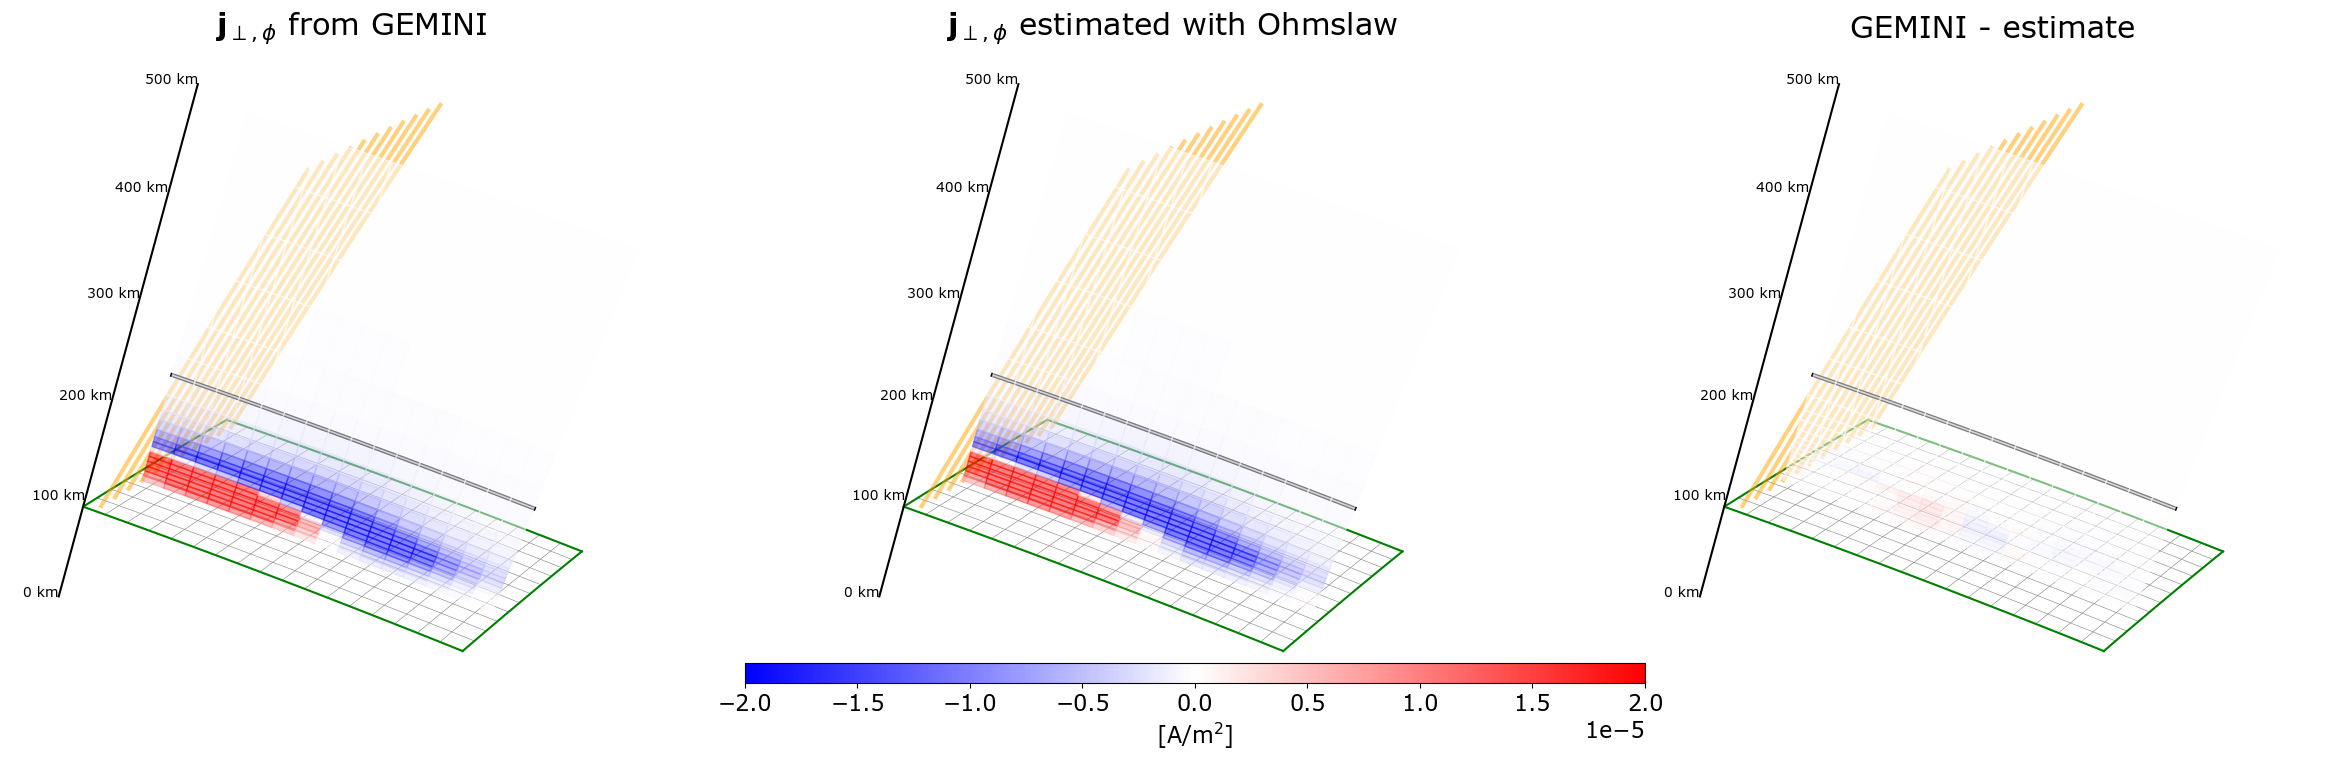

In [8]:
inputmode = 'vi_ohmslaw'

alts__ = gr.alts_grid[1:]-gr.altres[1:]
xi_e  = gr.grid.xi_mesh[0,1:] - gr.grid.dxi/2 
eta_e = gr.grid.eta_mesh[1:,0]- gr.grid.deta/2
alt_ev, eta_ev, xi_ev = np.meshgrid(alts__, eta_e, xi_e, indexing='ij')
lon_ev, lat_ev = gr.grid.projection.cube2geo(xi_ev, eta_ev) 
shape = lon_ev.shape
_data = data.data(gr, sim, beams=False, points=True, 
                  lat_ev=lat_ev, lon_ev=lon_ev, alt_ev=alt_ev, 
                  e3doubt_=False)
N = _data.lat.size
jjj = np.hstack((_data.jperpu,-_data.jperpn,_data.jperpe)) # jperp from GEMINI, in geo (r,theta,phi)
if not 'phitop' in inputmode:
    vperp = conv.get_E_from_lmodel(sim, _data, returnvperp=True)
    _data.vperp_electron = vperp
mod = model.model(gr)
inputdict = mod.make_inputdict(_data, gr, inputmode=inputmode, ext_factor=0, 
                    hp_from_brekke=False)
jperp_enu = np.vstack((inputdict['jperp'][0,:],inputdict['jperp'][1,:],inputdict['jperp'][2,:])).T
jjj2 = np.zeros((3,N))
jjj2[0,:] = jperp_enu[:,2]
jjj2[1,:] = -jperp_enu[:,1]
jjj2[2,:] = jperp_enu[:,0]

if inputmode=='vi':
    savesuff = '_' + inputmode + '-ve_'    
elif inputmode=='vi_ohmslaw':
    savesuff = '_Ohmslaw_'
else:
    savesuff = '_' + inputmode + '_'
inside = np.array([True]*N)
fig = diagnostics.compare_input_jperp(_data, jjj2, inside, 
                savesuff, gr.grid, gr.alts_grid, sliceindex=3, 
                maph=maph, dim=2, param='jperpphi', pdf=True)
if savefigs:
    fig.savefig('./plots/input_jperp_'+inputmode+'.pdf', dpi=250,bbox_inches='tight')

In [9]:
### Make the figure of the input jperp, only valid for the case when E3DOUBT is used to estimate variances

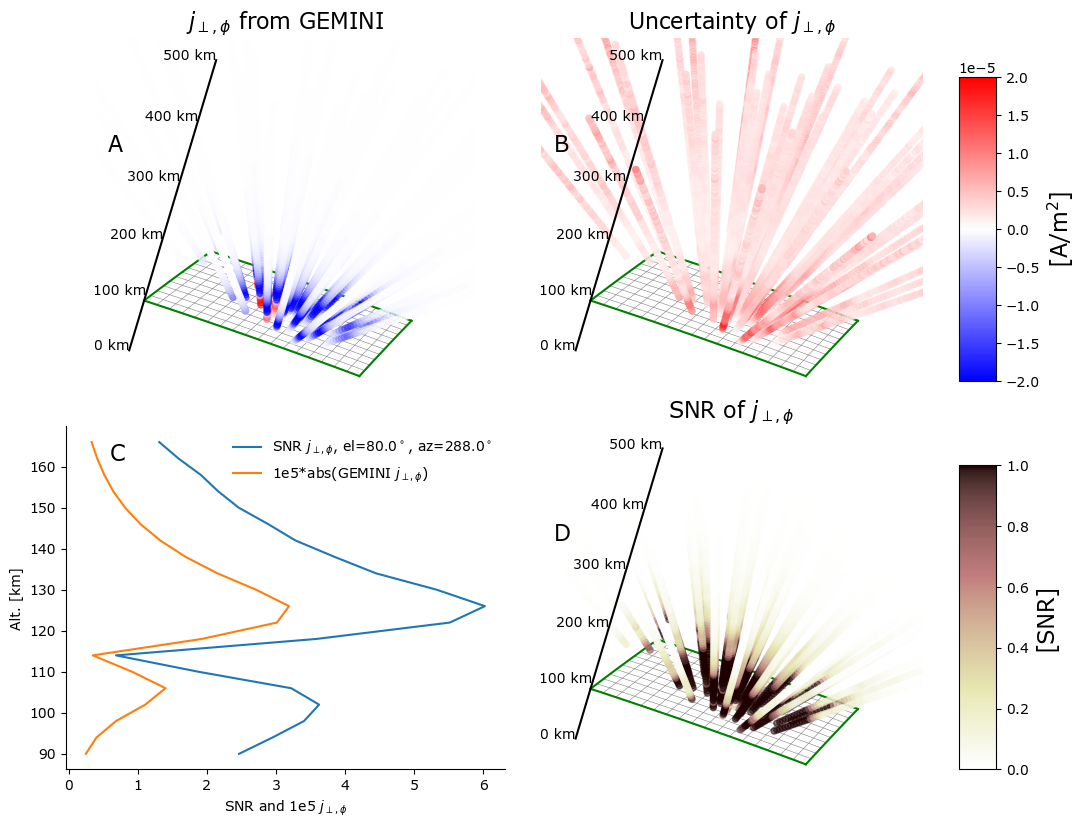

In [10]:
if not e3doubt_:
    print('This analysis can not be done unless E3DOUBT is used')
    breakpoint()    
fig = plt.figure(figsize=(12,10))
ax1 = plt.subplot2grid((20, 21), (0, 0), rowspan = 10, colspan = 10, projection='3d')
ax2 = plt.subplot2grid((20, 21), (0, 10), rowspan = 10, colspan = 10, projection='3d')
ax3 = plt.subplot2grid((20, 21), (10, 0), rowspan = 9, colspan = 10)
ax4 = plt.subplot2grid((20, 21), (10, 10), rowspan = 10, colspan = 10, projection='3d')

dat.dje =  np.sqrt(dat.cov_jperp[0,0,:])
dat.djn =  np.sqrt(dat.cov_jperp[1,1,:])
dat.SNRe = np.abs(dat.jperpe) / np.sqrt(dat.cov_jperp[0,0,:])
dat.SNRn = np.abs(dat.jperpn) / np.sqrt(dat.cov_jperp[1,1,:])
# datadict['sigma_ve'] = np.sqrt(datadict['cov_ve'][0,0,:])
# datadict['sigma_vn'] = np.sqrt(datadict['cov_ve'][1,1,:])
# datadict['sigma_vu'] = np.sqrt(datadict['cov_ve'][2,2,:])

clim = 2e-5  
ax1 = diagnostics.plot_analysis_grid(dat.__dict__, gr.grid, gr.alts_grid, 
                1, 1, 1, dipole_lompe=False, data=True, eiscat=True, _d=400, 
                q='jperpe', cmap='bwr', clim=clim, diverging=True, ax=ax1)
ax1.set_title(r'$j_{\perp, \phi}$ from GEMINI', fontsize=16)
ax1.text(1900,850, 6200, 'A', fontsize=16)
ax2 = diagnostics.plot_analysis_grid(dat.__dict__, gr.grid, gr.alts_grid, 
                1, 1, 1, dipole_lompe=False, data=True, eiscat=True, _d=400, 
                q='dje', cmap='bwr', clim=clim, diverging=True, ax=ax2) 
ax2.set_title(r'Uncertainty of $j_{\perp, \phi}$', fontsize=16)
ax2.text(1900,850, 6200, 'B', fontsize=16)

#Colorbar upper row
cbarax = plt.subplot2grid((20,21), (1, 20), rowspan = 8, colspan = 1)
cmap = plt.cm.bwr
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=-clim, vmax=clim)
cb1 = mpl.colorbar.ColorbarBase(cbarax, cmap=cmap,
                            norm=norm,
                            orientation='vertical')
cb1.set_label(r'[A/m$^2$]', fontsize=16)

clim=1
ax4 = diagnostics.plot_analysis_grid(dat.__dict__, gr.grid, gr.alts_grid, 
                1, 1, 1, dipole_lompe=False, data=True, eiscat=True, _d=400, 
                q='SNRe', cmap='pink_r', clim=clim, diverging=False, ax=ax4) 
ax4.set_title(r'SNR of $j_{\perp,\phi}$', fontsize=16)
ax4.text(1900,850, 6200, 'D', fontsize=16)

#Colorbar lower row
cbarax = plt.subplot2grid((20,21), (11, 20), rowspan = 8, colspan = 1)
cmap = plt.cm.pink_r
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=0, vmax=clim)
cb2 = mpl.colorbar.ColorbarBase(cbarax, cmap=cmap,
                            norm=norm,
                            orientation='vertical')
cb2.set_label('[SNR]', fontsize=16)

# SNR line plot   
use = np.where((dat.az_all==288) & (dat.el_all==80))[0]
N = dat.el_all.size
_az = dat.az_all[use[0]]
_el = dat.el_all[use[0]] 
s_str = r'SNR $j_{\perp,\phi}$, el=$%3.1f^\circ$, az=$%3.1f^\circ$' % (_el,_az)
ax3.plot(dat.SNRe[use[0]:use[0]+20], dat.alt[use[0]:use[0]+20], label=s_str)
# ax3.plot(datadict['SNRe'][N-nn:N-nn+20], datadict['alt'][N-nn:N-nn+20], label=s_str)
ax3.plot(np.abs(1e5*dat.jperpe[use[0]:use[0]+20]), dat.alt[use[0]:use[0]+20], label=r'1e5*abs(GEMINI $j_{\perp,\phi}$)')
# ax3.plot(np.abs(1e5*datadict['jperpe'][N-nn:N-nn+20]), datadict['alt'][N-nn:N-nn+20], label='1e5*abs(GEMINI $j_{\perp,\phi}$)')
ax3.legend(frameon=False)
ax3.set_xlabel('SNR and 1e5 $j_{\perp,\phi}$')
ax3.set_ylabel('Alt. [km]')
ax3.spines[['right', 'top']].set_visible(False)
ax3.text(0.1,0.9, 'C', fontsize=16, transform=ax3.transAxes)
if savefigs:
    fig.savefig('./plots/jperp_uncertainty.pdf',bbox_inches='tight')

In [14]:
print(gr.grid.L,gr.grid.Lres, gr.grid.W, gr.grid.Wres)

264490.27482030273 22959.225244817942 324728.1792931453 18792.140005390353


In [17]:
gr.grid.R - sim.RE*1000

90000.0